In [1]:
import torch
import torchvision
import numpy as np
from torch import nn
from torch.distributions import Normal
from torchvision import datasets 
from torchvision import transforms 
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
class Encodeur(nn.Module) :
    def __init__(self,dim_input,dim_output,dim_mu_sigma,device) :
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input,dim_output,device=device),
            nn.ReLU(),
            nn.Linear(dim_output,dim_output,device=device),
            nn.ReLU(),
        )
        self.mu = nn.Linear(dim_output,dim_mu_sigma,device=device)
        self.log_variance = nn.Linear(dim_output,dim_mu_sigma,device=device)
        
    def forward(self,x):
        x2 = self.network(x)
        mu = self.mu(x2)
        log_variance = self.log_variance(x2)
        return mu,log_variance

In [3]:
class Decodeur(nn.Module) :
    def __init__(self,dim_input,dim_output,dim_mu_sigma,device) :
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_mu_sigma,dim_output,device=device),
            nn.ReLU(),
            nn.Linear(dim_output,dim_output,device=device),
            nn.ReLU(),
            nn.Linear(dim_output,dim_input,device=device),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        return self.network(x)

In [4]:
def visualise_image(epoch,x,x_reconstruit):
    fig = plt.figure(figsize=(8, 4))
    
    ax1 = fig.add_subplot(121)
    ax1.set_title("Training Images Epoch " + str(epoch))
    ax1.axis('off')
    originals = torchvision.utils.make_grid(x.view(-1,1,28,28), padding=2, normalize=True)
    plt.imshow(np.transpose(originals,(1,2,0)))

    ax2 = fig.add_subplot(122)
    ax2.set_title("Reconstructions Epoch "+str(epoch))
    ax2.axis('off')
    reconstructed = torchvision.utils.make_grid(x_reconstruit.view(-1,1,28,28), padding=2, normalize=True)
    plt.imshow(np.transpose(reconstructed,(1,2,0)))

In [5]:
class VAE(nn.Module) :
    def __init__(self,dim_input,dim_output,dim_mu_sigma,device) :
        super().__init__()
        self.encodeur = Encodeur(dim_input,dim_output,dim_mu_sigma,device)
        self.decodeur = Decodeur(dim_input,dim_output,dim_mu_sigma,device)
        
        
    def sample(self,mu,log_variance):
        sigma = torch.exp(0.5 * log_variance)
        distribution = Normal(0,1)
        eps = distribution.rsample(sigma.size())
        return mu + (eps * sigma)
        
    def forward(self,x):
        mu,log_variance = self.encodeur(x)
        z = self.sample(mu,log_variance)
        x_reconstruit = self.decodeur(z)
        return mu,log_variance,z,x_reconstruit

In [6]:
class LossVAE() :
    
    def loss_reconstruction(self,x,x_reconstruit):
        return nn.functional.binary_cross_entropy(x, x_reconstruit,reduction="sum")
    
    def loss_kullback_leibler(self ,mu ,log_variance):
        return -0.5 * torch.sum( 1 +  log_variance - mu.pow(2) - log_variance.exp() )
    
    def loss(self,mu ,log_variance,x,x_reconstruit):
        reconstruction = self.loss_reconstruction(x,x_reconstruit)
#         print(reconstruction)
        kullback_leibler = self.loss_kullback_leibler( mu ,log_variance)
#         print(kullback_leibler)
        return reconstruction + kullback_leibler

In [7]:
trnsform = transforms.Compose([ transforms.ToTensor(),transforms.Lambda(lambda x : x / 255)])                                    
train = datasets.MNIST(root='./data', train=True, download=True,transform=trnsform)
test = datasets.MNIST(root='./data', train=False, download=True, transform=trnsform)
loader_train = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
loader_test = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

In [8]:
train.data.shape

torch.Size([60000, 28, 28])

In [9]:
test.data.shape

torch.Size([10000, 28, 28])

In [10]:
dim_input = 28 * 28
dim_output = 20 * 20
dim_mu_sigma = 2
device = 'cpu'
epochs = 10
lr = 0.0001

In [11]:
vae = VAE(dim_input,dim_output,dim_mu_sigma,device)
lossVAE = LossVAE()
opt = torch.optim.Adam(vae.parameters(),lr=lr)

In [ ]:
loss_train = []
loss_test = []

for epoch in tqdm(range(epochs)) :
    
    tmp_train = []
    
    for x,y in loader_train :
        x = x.view(10,-1)
        mu,log_variance,_,x_reconstruit = vae(x)
        loss = lossVAE.loss(mu,log_variance,x,x_reconstruit)
        loss.backward()
        opt.zero_grad()
        opt.step()
        tmp_train.append(loss.detach())
        if epoch % 2 == 0 : visualise_image(epoch,x,x_reconstruit)
            
            

    
    loss_train.append(torch.tensor(tmp_train).mean())
    print(loss_train)
    
    tmp_test = []
    for x,y in loader_test :
        with torch.no_grad():
            x = x.view(10,-1)
            mu,log_variance,_,x_reconstruit = vae(x)
            loss = lossVAE.loss(mu,log_variance,x,x_reconstruit)
            tmp_test.append(loss.detach())
            if epoch % 2 == 0 : visualise_image(epoch,x,x_reconstruit)
                
    loss_test.append(torch.tensor(tmp_test).mean())
    print(loss_test)
           
        

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]<ipython-input-4-e5110f17ff48>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8, 4))


[tensor(321177.8125)]


 10%|████████                                                                        | 1/10 [11:39<1:44:58, 699.89s/it]

[tensor(320607.3750)]
[tensor(321177.8125), tensor(321179.5312)]


 20%|████████████████▍                                                                 | 2/10 [14:32<51:58, 389.79s/it]

[tensor(320607.3750), tensor(320598.7500)]


In [12]:
loss_train

[tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan),
 tensor(nan)]

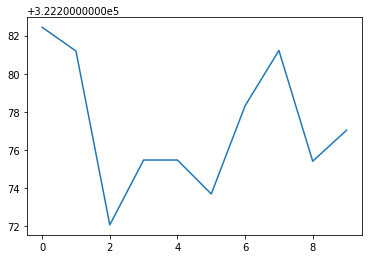

In [15]:
plt.plot(loss_test)

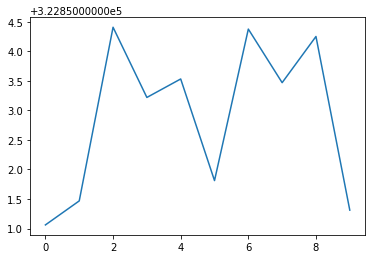

In [14]:
plt.plot(loss_train)

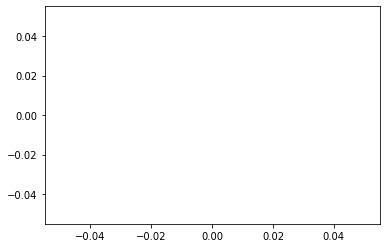